In [1]:
import os
import time
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd

from IPython import display

In [2]:
tf.__version__

'2.5.0'

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
def make_generator_model(input_shape, output_shape, initial_shape, initial_n_filters):
    output_shape_len = output_shape[1]
    n_super_layers = max(2, int(output_shape_len / initial_shape / 2) - 1)
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(initial_shape*initial_shape*initial_n_filters, use_bias=False, input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((initial_shape, initial_shape, initial_n_filters)))
    assert model.output_shape == (None, initial_shape, initial_shape, initial_n_filters)

    stride = 1
    for i in range(n_super_layers):
        n_filters = int(initial_n_filters / (2**i))
        output_len = initial_shape * (2**i)
        model.add(layers.Conv2DTranspose(n_filters, (5, 5), strides=(stride, stride), padding='same', use_bias=False))
        assert model.output_shape == (None, output_len, output_len, n_filters)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        stride = 2

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == output_shape

    return model

In [8]:
generator = make_generator_model((100,), (None, 28, 28, 1), 7, 128)

In [9]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              627200    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         409600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

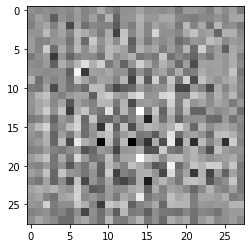

In [10]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [11]:
def make_discriminator_model(input_shape, initial_n_filters, n_super_layers):
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(initial_n_filters, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    for i in range(n_super_layers):
        n_filters = int(initial_n_filters * (2**(i+1)))
        model.add(layers.Conv2D(n_filters, (5, 5), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [12]:
discriminator = make_discriminator_model((28, 28, 1), 32, 1)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)             

In [13]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00059283]], shape=(1, 1), dtype=float32)


In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [19]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [20]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [21]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

In [22]:
def train(dataset, epochs):
    res_metrics = pd.DataFrame(columns=['epoch', 'batch', 'gen_loss', 'disc_loss'])

    for epoch in range(epochs):
        start = time.time()

        for i, image_batch in enumerate(dataset):
            gen_loss, disc_loss = train_step(image_batch)
            to_append = {
                'epoch': epoch,
                'batch': i,
                'gen_loss': gen_loss.numpy(),
                'disc_loss': disc_loss.numpy()
                }
            res_metrics = res_metrics.append(to_append, ignore_index=True)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)

        if (epoch+1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print(f'Time for epoch {epoch+1} is: {time.time()-start:.0f} seconds,'
              f' generator loss: {gen_loss:.2f}, discriminator loss: {disc_loss:.2f}.')

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

    return res_metrics

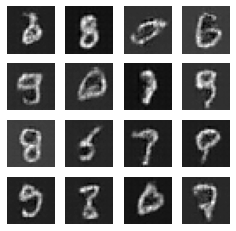

In [23]:
res_metrics = train(train_dataset, EPOCHS)

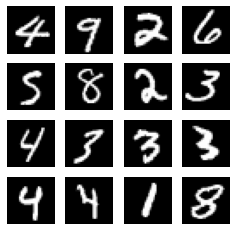

In [24]:
fig = plt.figure(figsize=(4, 4))
for i, e in enumerate(train_dataset.unbatch().take(16)):
    plt.subplot(4, 4, i+1)
    plt.imshow(e[:, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

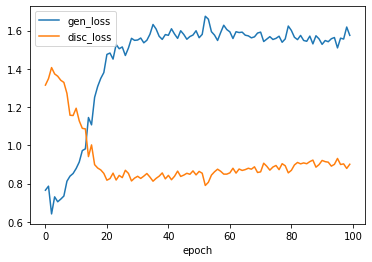

In [25]:
res_metrics.groupby('epoch').mean()[['gen_loss', 'disc_loss']].plot()
plt.show()

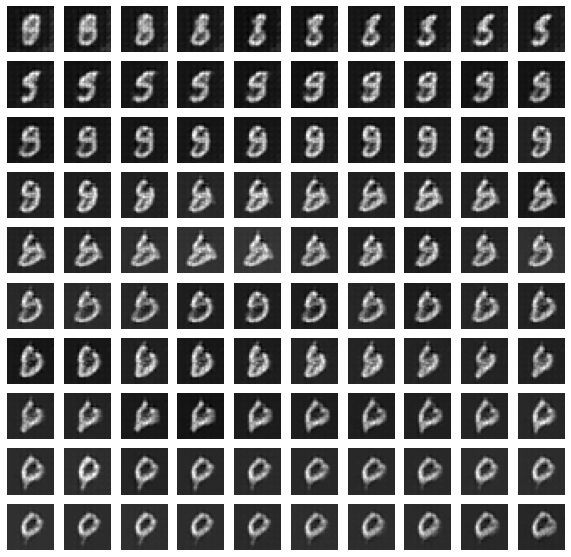

In [27]:
fig = plt.figure(figsize=(10, 10))
noise_len = 100
for i in range(noise_len):
    noise_arr = [1] * i + (noise_len - i) * [0]
    plt.subplot(10, 10, i+1)
    plt.imshow(generator(tf.constant([noise_arr]), training=False)[0, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()